IBM Sample Dataset has information about Telco customers churn,
customer’s services, account and demographic data.

- comparison between leaving and staying customers ratio
- investigate main reasons for the customers to leave or stay
- find out how gender, partnership, dependency and age affects the development
- show the corelations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=UserWarning)
sns.set(style="white")
from pathlib import Path

Checking the data

In [2]:
DATA_PATH = Path(__name__).resolve().parent.parent.joinpath("data").joinpath("Customer-Churn.csv")

In [3]:
def read_csv_to_df(path: Path) -> pd.DataFrame:
    """Function to read csv into df
    param: path: Path to the file
    """
    _df = pd.read_csv(path)
    return _df

 Impute missing values with zero

In [4]:
raw_df = read_csv_to_df(DATA_PATH)
raw_df['TotalCharges']=raw_df['TotalCharges'].replace(" ", 0).astype('float32') # replacing empty fields of total charge column with 0, customer never paid any thing

In [5]:
raw_df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734375
std,0.368612,24.559481,30.090047,2266.794434
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.549988
50%,0.000000,29.000000,70.350000,1394.550049
75%,0.000000,55.000000,89.850000,3786.599976
max,1.000000,72.000000,118.750000,8684.799805


In [6]:
# some print functions are added to describe the shape, lenght of data 

def describe_the_data(df: pd.DataFrame) -> None:
    print("Total columns in dataframe: {}".format(len(df.columns)))
    print("Total Dimention of the dataframe: {}".format(df.shape))
    null_report_df = pd.DataFrame(df.isnull().sum(), columns=["null_count"]).reset_index()
    null_report_df = null_report_df[null_report_df["null_count"] > 0]
    if len(null_report_df) > 0:
        print("Following columns has null values:")
        print(null_report_df.to_dict(orient="records"))
    else:
        print("There is no null values in the dataframe")

In [7]:
describe_the_data(raw_df)

Total columns in dataframe: 21
Total Dimention of the dataframe: (7043, 21)
There is no null values in the dataframe


Catagorical count plot to check amount of customers left vs staying. It uses Yes, No boolean value

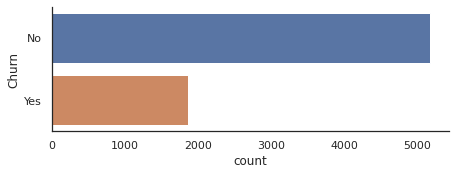

In [8]:
# to check how many clients left the company we are taking boolian data from column churn
# ration of customers leving in the last month is below the half ammount of staying
ax = sns.catplot(y="Churn", kind="count", data=raw_df, height=2.6, aspect=2.5,orient='h') 

In [9]:
# storing yes and no variables from a specific column name, the churn column gets devided into two different catagories
def get_feature_by_churn(df: pd.DataFrame, colname: str) -> dict:
    churn_yes = df[df['Churn'] == 'Yes'][colname].dropna()
    churn_no = df[df['Churn'] == 'No'][colname].dropna()
    return {"yes": churn_yes, "no": churn_no}

__probability density destribution depending on three columns(tenure,monthly charges, total charges)__
- results, recent clients are more likely to churn
- clients with higher monthly charges also likely to churn
- Tenure(years of ownership) and monthly charges are mostly important features

In [10]:
# assining properties to the Kde plot
def kdeplot_by_selected_feature(data: dict, title: str) -> None:
    plt.figure(figsize=(9,4))
    plt.title("KDE for {}".format(title.capitalize()))
    sns.kdeplot(data["no"], color = 'navy', label = 'Churn: No' )
    sns.kdeplot(data["yes"], color = 'orange', label = 'Churn: Yes')
    plt.set_xticks =(range(5))
    plt.legend(loc='upper right')

In [11]:
def generate_kde_plots(df: pd.DataFrame, col_list: list) -> None:
    for colname in col_list:
        data_dict = get_feature_by_churn(df, colname)
        kdeplot_by_selected_feature(data_dict, colname)

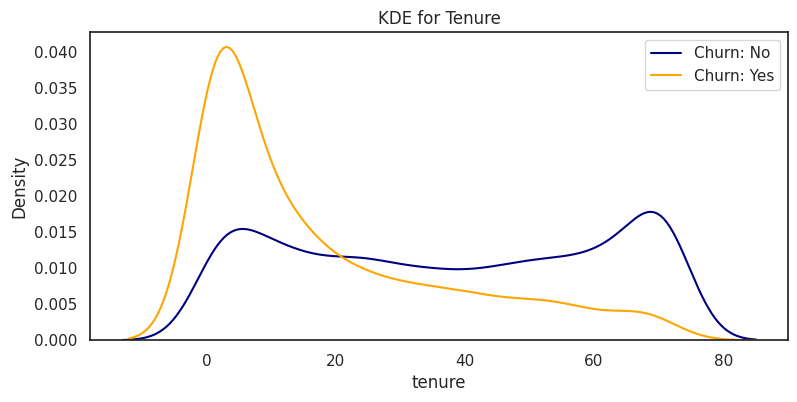

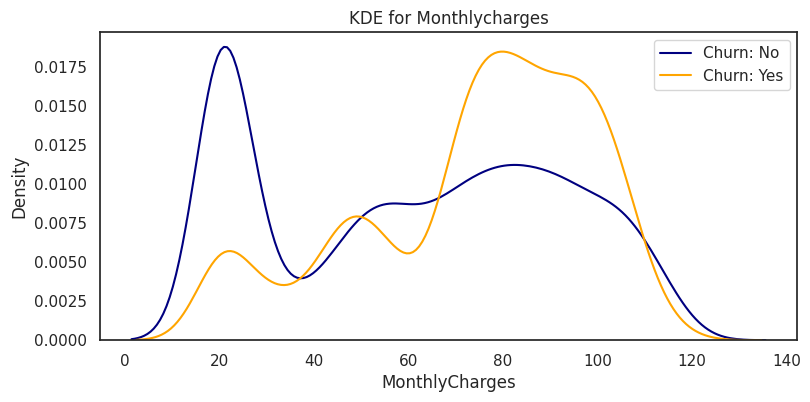

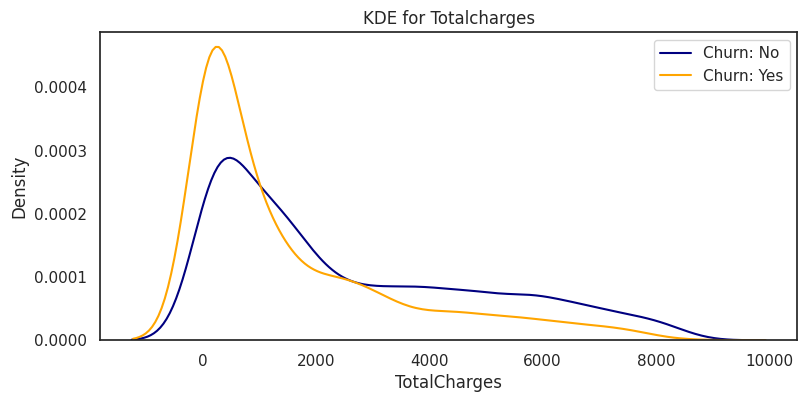

In [12]:
# as these three has numeric features so the kde plot can be used to check the randomness of the data and make a smooth estimation.
generate_kde_plots(df=raw_df, col_list=["tenure", "MonthlyCharges", "TotalCharges"])

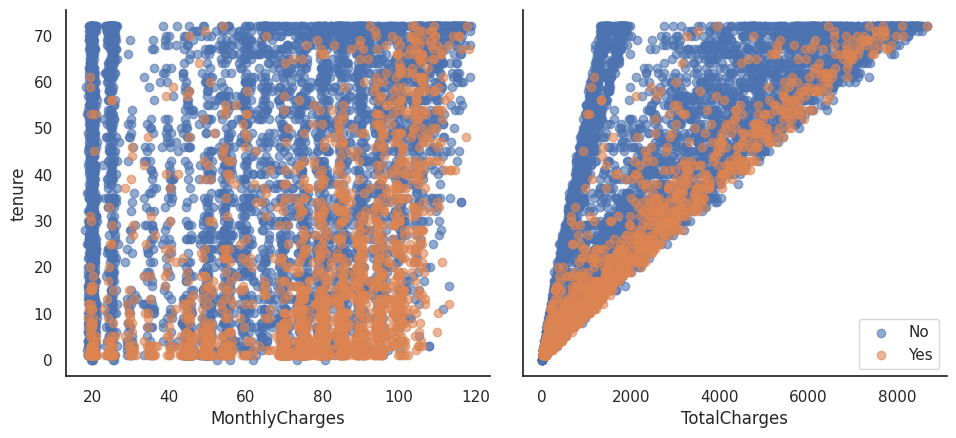

In [13]:
# we can observe bounderies when we use scatterplot, showing us density of leaving and staying due to increase of total and monthly charge
#Newer customers are dense in the lower reagion and they are leaving with increasing monthly fee
g = sns.PairGrid(raw_df, y_vars=["tenure"], x_vars=["MonthlyCharges", "TotalCharges"], height=4.5, hue="Churn", aspect=1.1)
ax = g.map(plt.scatter, alpha=0.6)
plt.legend()

In [14]:
#monthly and total charges dived by tenure
#function loades any df and applies mathematical or logical operations over it
def add_monthly_charges_diff(df: pd.DataFrame) -> pd.DataFrame:
    _df = df.copy()
    _df['total_charges_to_tenure_ratio'] = _df['TotalCharges'] / _df['tenure']
    _df['monthly_charges_diff'] = _df['MonthlyCharges'] - _df['total_charges_to_tenure_ratio']
    return _df

In [15]:
processed_df = add_monthly_charges_diff(df=raw_df)

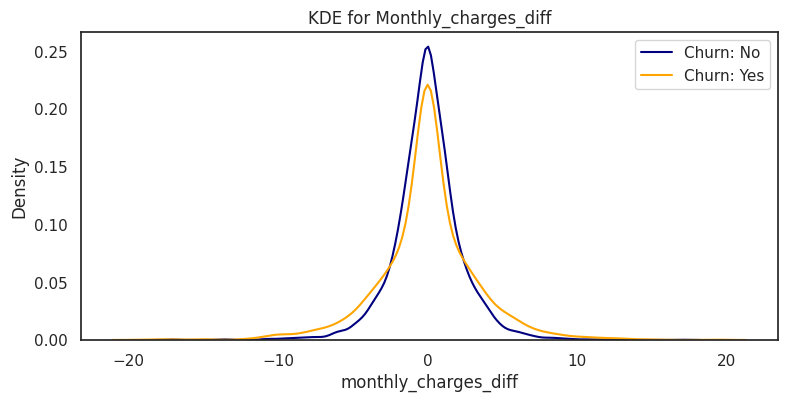

In [16]:
generate_kde_plots(df=processed_df, col_list=["monthly_charges_diff"])
plt.legend()

Anaylising catagorical features
Effects due to gender and Age

In [17]:
raw_df.groupby("SeniorCitizen")["Churn"].value_counts().to_frame().rename(columns={"Churn": "total_count"}).reset_index()

,SeniorCitizen,Churn,total_count
0,0,No,4508
1,0,Yes,1393
2,1,No,666
3,1,Yes,476


In [18]:
# transforming the data into a new frame according to churn and total count of senior citizen
#to calculate the the percentage using total ammount of people or rows 
def calculate_customer_pct(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    new_col_name = "total_count"
    _df = (
        df
        .groupby(feature)["Churn"]
        .value_counts()
        .to_frame()
        .rename(columns={"Churn": new_col_name})
        .reset_index()
    )
    _df["percentage_of_customers"] = _df[new_col_name]/len(df)
    return _df
    

In [19]:
calculate_customer_pct(processed_df, "SeniorCitizen")

,SeniorCitizen,Churn,total_count,percentage_of_customers
0,0,No,4508,0.640068
1,0,Yes,1393,0.197785
2,1,No,666,0.094562
3,1,Yes,476,0.067585


In [20]:
# Six binary features (Yes/No)
# Nine features with three unique values each (categories)
# One feature with four unique values
# making a barplot to compare between the data.
def barplot_percentages(df, colname: str, orient='v'):
    axis_name="percentage_of_customers"
    if orient == 'v':
        ax = sns.barplot(x = colname, y = axis_name, hue = 'Churn', data = df, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
        ax.plot()
    else:
        ax = sns.barplot(x= axis_name, y=colname, hue = 'Churn', data = df, orient = orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
        ax.plot()

/tmp/ipykernel_22555/413604073.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


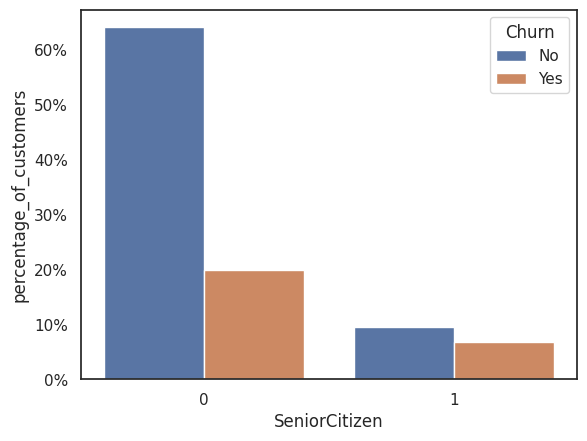

In [21]:
calculated_customer_pct = calculate_customer_pct(processed_df, "SeniorCitizen")
barplot_percentages(calculated_customer_pct, "SeniorCitizen")

SeniorCitizens have a much higher churn rate
And it is not devending on Gender

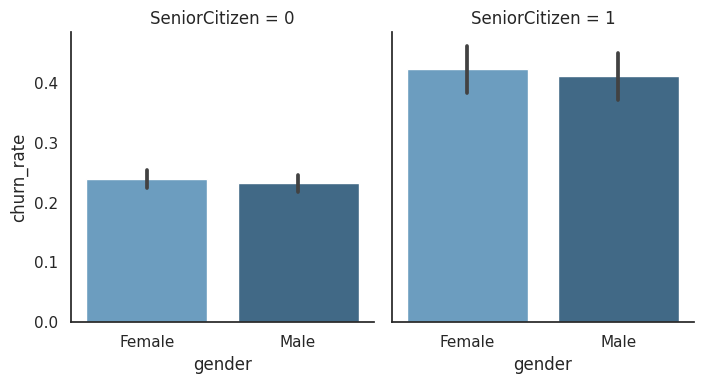

In [22]:
# deviding the citizens according to their gender
# creating multiplot grid that creates conditional relation between the columns
raw_df['churn_rate'] = raw_df['Churn'].replace("No", 0).replace("Yes", 1) # a new column by replacing yes/no with 1/0
g = sns.FacetGrid(raw_df, col="SeniorCitizen", height = 4, aspect = .9)
ax = g.map(sns.barplot, "gender", "churn_rate", palette = "Blues_d", order=['Female', 'Male']) # in the facitgrid for g,  gender and churn_rate comparison bar plot

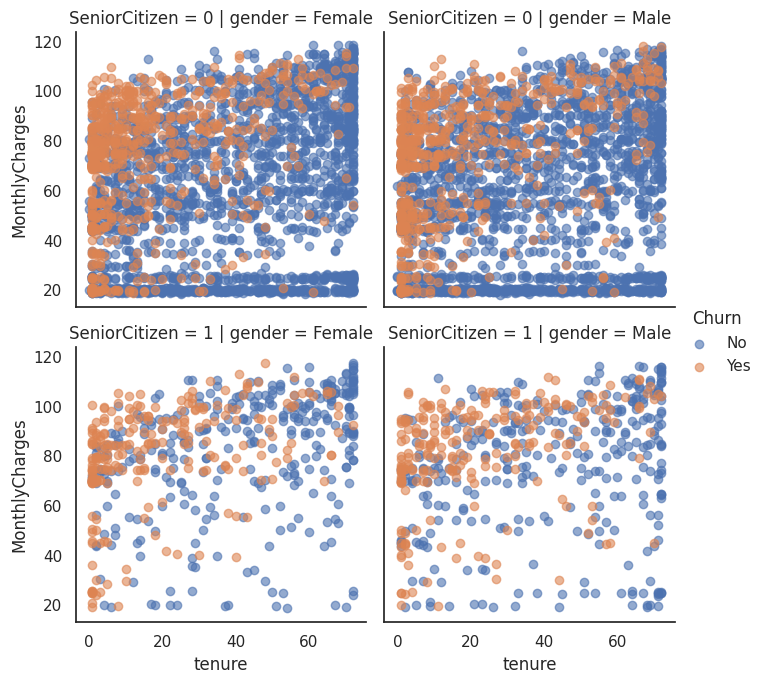

In [23]:
# Senior citizen and gender wise tenure vs monthly charge scatter plots 
g = sns.FacetGrid(raw_df, row = 'SeniorCitizen', col = "gender", hue = "Churn", height = 3.5)
g.map(plt.scatter, "tenure", "MonthlyCharges", alpha=0.6)
g.add_legend();

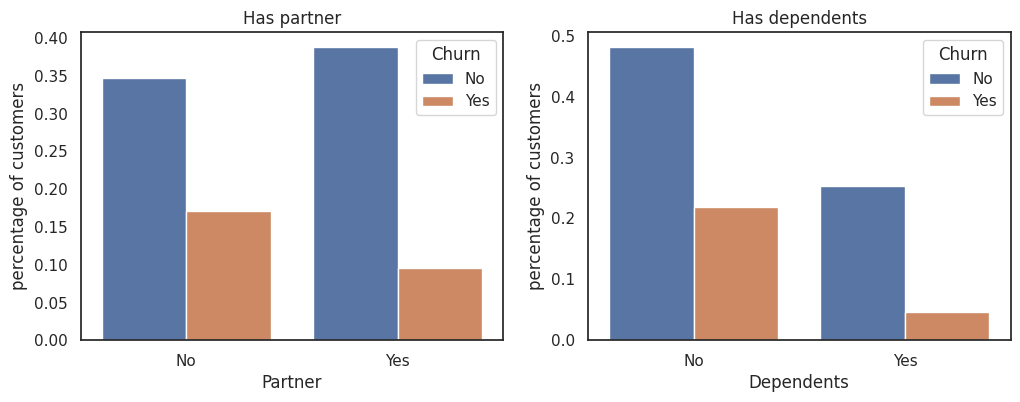

In [24]:
# customers with no partners are more likely to churn
fig, axis = plt.subplots(1, 2, figsize=(12,4))
axis[0].set_title("Has partner")
axis[1].set_title("Has dependents")
axis_y = "percentage of customers"

# grouping the data according to churn vs partner and churn verses dependents
gp_partner = raw_df.groupby('Partner')["Churn"].value_counts()/len(raw_df)
gp_partner = gp_partner.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()

ax = sns.barplot(x='Partner', y=axis_y, hue='Churn', data=gp_partner, ax=axis[0]) #creating barplot

gp_dep = raw_df.groupby('Dependents')["Churn"].value_counts()/len(raw_df)
gp_dep = gp_dep.to_frame().rename({"Churn": axis_y}, axis = 1).reset_index()

ax = sns.barplot(x = 'Dependents', y = axis_y, hue = 'Churn', data = gp_dep, ax = axis[1])

In [25]:
#creating the new data frame to make the plot for multiline
calculated_customer_pct_mpl = calculate_customer_pct(processed_df, "MultipleLines")
calculated_customer_pct_mpl

,MultipleLines,Churn,total_count,percentage_of_customers
0,No,No,2541,0.360784
1,No,Yes,849,0.120545
2,No phone service,No,512,0.072696
3,No phone service,Yes,170,0.024137
4,Yes,No,2121,0.301150
5,Yes,Yes,850,0.120687


Customers with multiple lines have a slightly higher churn rate

/tmp/ipykernel_22555/413604073.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


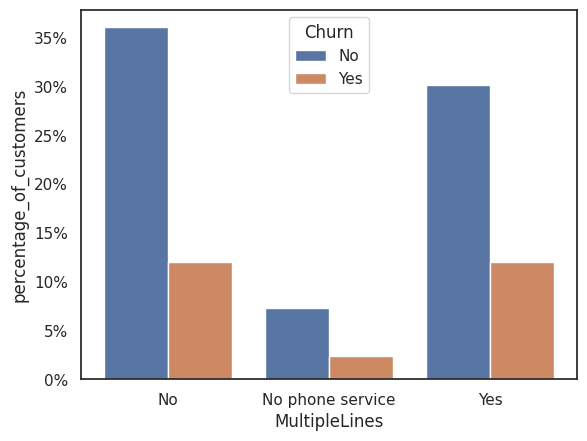

In [26]:
barplot_percentages(calculated_customer_pct_mpl, "MultipleLines")# using the function for bar plot 

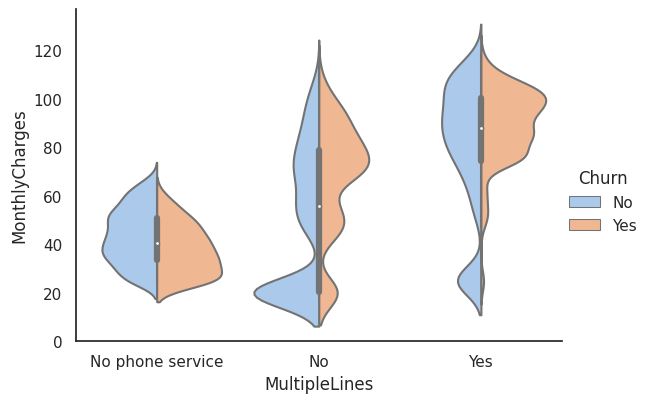

In [27]:
# for increasing monthly charge it shows the spread of churn
ax = sns.catplot(
    x="MultipleLines", y = "MonthlyCharges",
    hue="Churn", kind="violin", split= True, 
    palette="pastel", data=raw_df, height=4.2, aspect=1.4
)

/tmp/ipykernel_22555/413604073.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])


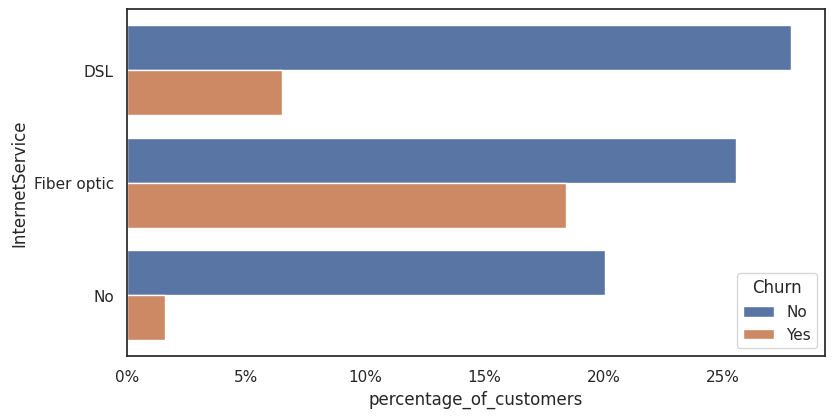

In [28]:
#using the percentage calculation function and the processed data frame
calculated_customer_pct_IS = calculate_customer_pct(processed_df, "InternetService")
plt.figure(figsize=(9,4.5))
barplot_percentages(calculated_customer_pct_IS,"InternetService", orient='h')

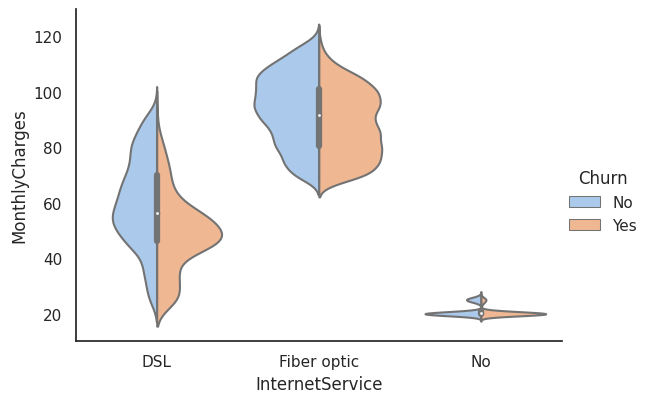

In [29]:
ax = sns.catplot(x="InternetService", y="MonthlyCharges",
                 hue="Churn", kind="violin", split=True, palette="pastel", data=raw_df, height=4.2, aspect=1.4);

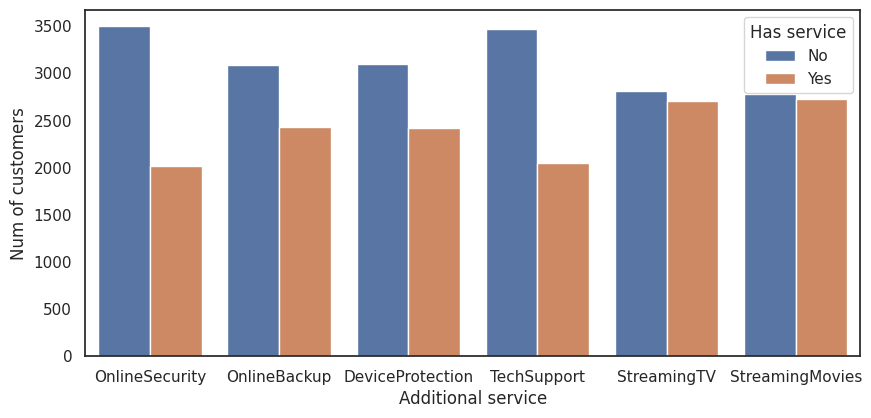

In [30]:
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df1 = pd.melt(raw_df[raw_df["InternetService"] != "No"][cols]).rename({'value':'Has service'}, axis=1)
plt.figure(figsize=(10, 4.5))
ax = sns.countplot(data=df1, x='variable', hue='Has service')
ax.set(xlabel='Additional service', ylabel='Num of customers')
plt.show()

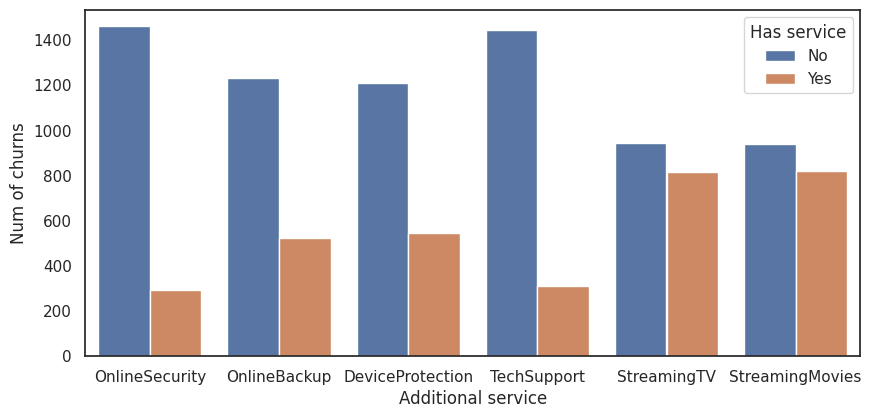

In [31]:
plt.figure(figsize=(10,4.5))
df1 = processed_df[(processed_df.InternetService != "No") & (processed_df.Churn == "Yes")]
df1 = pd.melt(df1[cols]).rename({'value': 'Has service'}, axis=1)
ax = sns.countplot(data = df1, x='variable', hue = 'Has service', hue_order=['No', 'Yes'])
ax.set(xlabel='Additional service', ylabel='Num of churns')
plt.show()

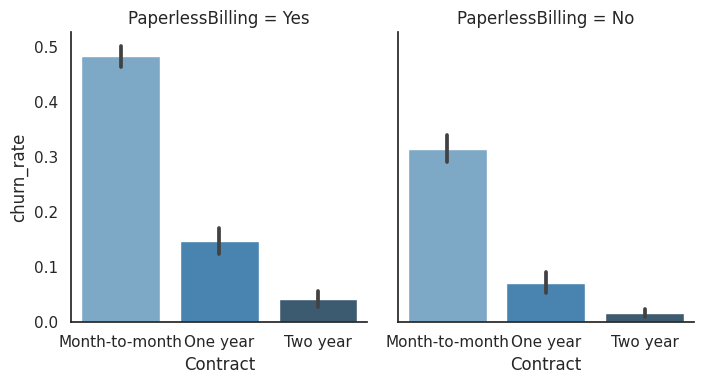

In [32]:
g = sns.FacetGrid(raw_df, col="PaperlessBilling", height=4, aspect=0.9)
ax = g.map(sns.barplot, "Contract", "churn_rate", palette = "Blues_d", order = ['Month-to-month', 'One year', 'Two year'])

/tmp/ipykernel_22555/413604073.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])


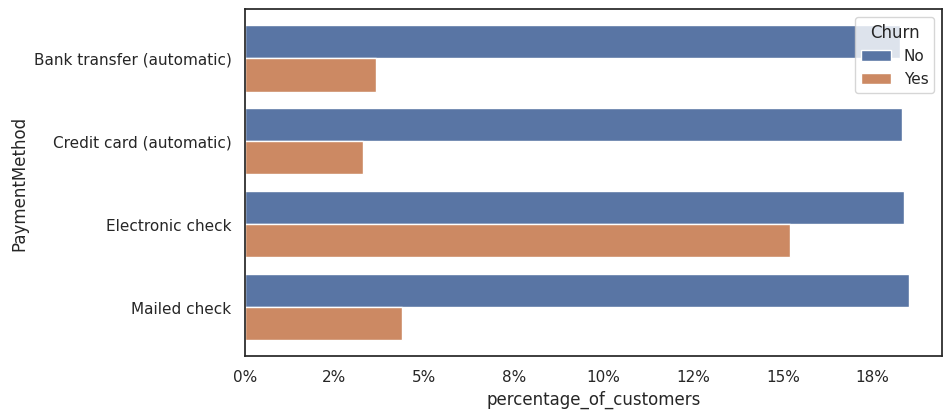

In [33]:
calculated_customer_pct_pm = calculate_customer_pct(processed_df, "PaymentMethod")
plt.figure(figsize=(9,4.5))
barplot_percentages(calculated_customer_pct_pm,"PaymentMethod", orient ='h')

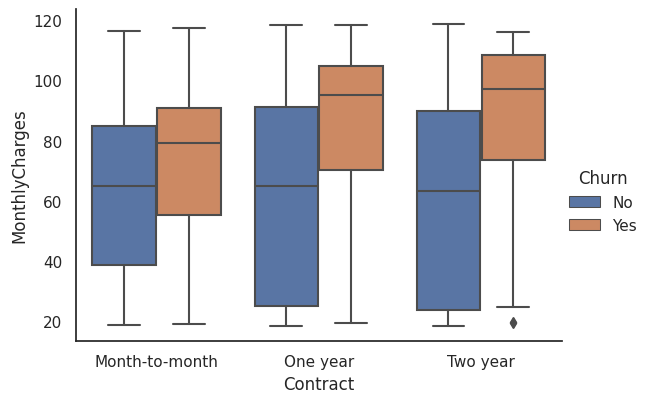

In [34]:
ax = sns.catplot(x="Contract", y="MonthlyCharges", hue="Churn", kind="box", data=raw_df, height=4.2, aspect=1.4)

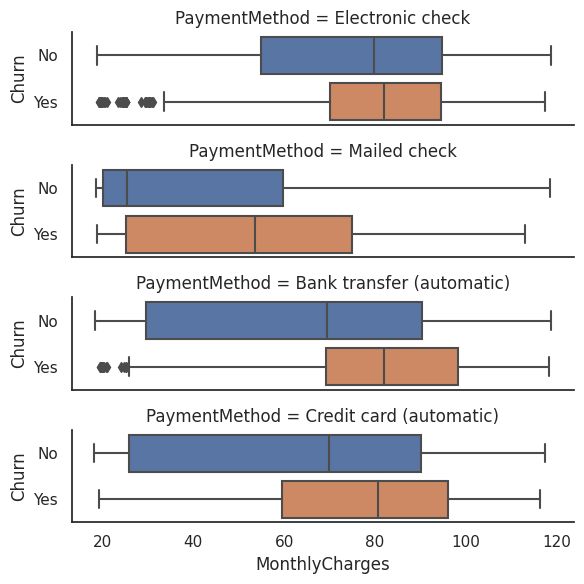

In [35]:
ax = sns.catplot(y = "Churn", x="MonthlyCharges", row = "PaymentMethod", kind="box", data=raw_df, height=1.5, aspect=4, orient='h')

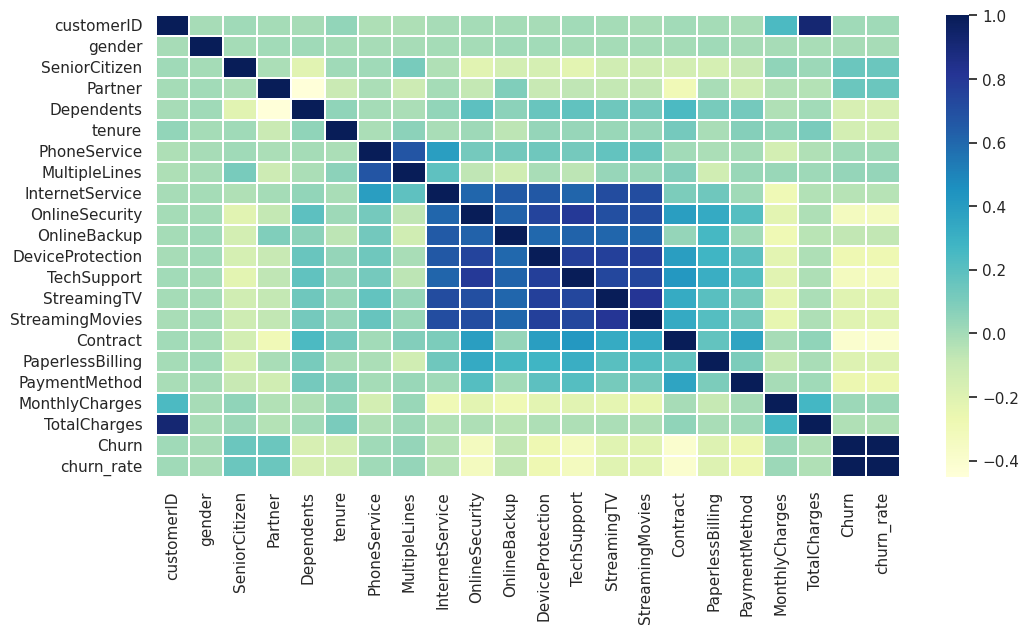

In [37]:
# heatmap for checking correlations
plt.figure(figsize=(12,6))
# raw_df.drop(['customerID', 'churn_rate', 'total_charges_to_tenure_ratio', 'monthly_charges_diff'], axis=1, inplace=True)
corr = raw_df.apply(lambda x : pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, linewidths =.2, cmap ="YlGnBu")

In [ ]:
raw_df.head(5)

In [ ]:
# params = {'random_state': 0, 'n_jobs':4, 'n_estimators':5, 'max_depth':8}
# raw_df = pd.get_dummies(raw_df)
# drop = ['Churn_Yes', 'Churn_No', 'gender_Female', 'Partner_No', 'Dependents_No', 'PhoneService_No', 'PaperlessBilling_No']
# x, y = raw_df.drop(drop, axis=1).dropna(), raw_df['Churn_Yes']

In [160]:
x["total_charges_to_tenure_ratio"] = x["total_charges_to_tenure_ratio"].fillna(x["total_charges_to_tenure_ratio"].mean())

In [ ]:
# x["monthly_charges_diff"] = x["monthly_charges_diff"].fillna(x["monthly_charges_diff"].mean())

In [ ]:
# clf = RandomForestClassifier(**params)
# clf = clf.fit(x,y)

# imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
# plt.figure(figsize=(10,12))
# plt.title("Feature importance")
# ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')